**Μοντέλο επιλογής:**
Σε αυτό το ερώτημα θα επιλέξουμε το μοντέλο του *CNN*,καθώς είχε καλύτερα αποτελέσματα από αυτό του LSTM.

**Περιγραφή του [5] σύνδεσμου:**
    Το συγκεκριμένο paper "How transferable are features in deep neural nertworks?"  αναφέρει το κατά πόσο είναι εύλογο να εκπαιδεύσουμε ένα νευρωνικό δίκτυο σε άλλοο τασκ και να μεταφέρουμε τα βάρη του για να προβλέψουμε κάποιο άλλο. Κάποια από αυτά τα συμπεράσματα είναι τα εξής:

1. Καλό είναι να χρησιμοποιούμε τα βάρη των layer που δεν είναι πολύ βαθιά καθώς είναι πιο γενικά τα χαρακτηριστικά που εξάγουν, ενώ τα τελευταία επίπεδα που είναι πιο ειδικευμένα πάνω στο τασκ που έχουνε αναλάβει , δε θα προσφέρουν πολλά στο δικό μας δίκτυο.
2. Η μεταφορά των weights από ένα μοντέλο σε ένα άλλο και η μετεκπαίδευση τους(fine tuning) μπορεί να προσφέρει στην αποφυγή του overfit και την πραγματοποίηση του generalization, ανεξαρτήτως μεγέθους των δεδομένων μας καθώς τα βάρη που έχουμε μεταφέρει θα συνεχίσουν να είναι ίδια και στη συνέχεια. Αυτό που θα αλλάζει είναι τα επόμενα layers που θα επικεντρώνονται στο συγκεκριμένο τασκ που έχουμε.
3. Σημαντικό είναι πως η μεθοδολογία αυτή δεν έχει πολύ νόημα αν τα tasks δε μοιάζουν μεταξύ τους.
4. Τέλος, υπάρχει ένα ακόμα θέμα το οποίο μπορεί να φέρει επιπτώσεις στην απόδοση του transfer learning. Αυτό είναι το fragile co-adapted features, που συμβαίνει όταν τα layers του δικτύου διαμορφώνονται, κατά την εκπαίδευση αλλά ταυτόχρονα επηρεάζονται και από άλλα layers. Επομένως, όταν εμείς μεταφέρουμε αυτό το κομμάτι , πλέον δε θα έχει την ίδια αλληλεπίδραση με τα layer που είχε στο προηγούμενο δίκτυο. Αυτό το πρόβλημα αφορά κυρίως τα μεσαία layers.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [1]:
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Combine similar classes and remove underrepresented classes
class_mapping = {
    'Rock': 'Rock',
    'Psych-Rock': 'Rock',
    'Indie-Rock': None,
    'Post-Rock': 'Rock',
    'Psych-Folk': 'Folk',
    'Folk': 'Folk',
    'Metal': 'Metal',
    'Punk': 'Metal',
    'Post-Punk': None,
    'Trip-Hop': 'Trip-Hop',
    'Pop': 'Pop',
    'Electronic': 'Electronic',
    'Hip-Hop': 'Hip-Hop',
    'Classical': 'Classical',
    'Blues': 'Blues',
    'Chiptune': 'Electronic',
    'Jazz': 'Jazz',
    'Soundtrack': None,
    'International': None,
    'Old-Time': None
}

def torch_train_val_split(dataset, batch_train, batch_eval,val_size=.2, shuffle=True, seed=None):
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    return train_loader, val_loader


def read_fused_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)
    return spectrogram.T


def read_mel_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[:128]
    return spectrogram.T

    
def read_chromagram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[128:]
    return spectrogram.T


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])



class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value
    #https://stackoverflow.com/questions/9663562/what-is-the-difference-between-init-and-call
    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length]

        if len(s) < self.max_length:
            #https://www.geeksforgeeks.org/copy-python-deep-copy-shallow-copy/
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1
        
class SpectrogramDataset(Dataset):
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, read_spec_fn=read_fused_spectrogram,sort=True):
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index, class_mapping)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        
        # not working for a reason...
        if sort:
            self.indexes = list(range(len(self.lengths)))
            self.indexes.sort(key=self.lengths.__getitem__, reverse=True)
            self.lengths = list(map(self.lengths.__getitem__, self.indexes))
            #print(self.lengths)
            self.feats = list(map(self.feats.__getitem__, self.indexes))
            #print([f.shape for f in self.feats] )
            labels = list(map(labels.__getitem__, self.indexes))
        
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(self.label_transformer.fit_transform(labels)).astype('int64')
        #print([f.shape for f in self.feats] )

    def get_files_labels(self, txt, class_mapping):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            label = l[1]
            if class_mapping:
                label = class_mapping[l[1]]
            if not label:
                continue
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = l[0].split('.')[0]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
        return files, labels
    
    

    def __getitem__(self, item):
        # TODO: Inspect output and comment on how the output is formatted
        l = min(self.lengths[item], self.max_length)
        return np.expand_dims(self.zero_pad_and_stack(self.feats[item]), 0), self.labels[item], l
        
    
    def __len__(self):
        return len(self.labels)

In [2]:
sort = False
#train val set
fused_specs = SpectrogramDataset(
         '/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_fused_spectrogram)

train_loader_fused, val_loader_fused = torch_train_val_split(fused_specs, 32 ,32, val_size=.1)

#test
test_loader_fused = SpectrogramDataset(
          '/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_fused_spectrogram)

dataloaders = {'train':train_loader_fused,'val':val_loader_fused}

test_loader = DataLoader(test_loader_fused,batch_size=32)


In [3]:
import numpy as np
import torch
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [4]:
import torch.nn as nn
class Layers(nn.Module):
    def __init__(self,in_c,out_c):
        super(Layers,self).__init__()
        self.conv = nn.Conv2d(in_channels=in_c,kernel_size=5,out_channels=out_c,stride=1,padding=2)
        self.bn = nn.BatchNorm2d(num_features=out_c)
        self.pool = nn.MaxPool2d(2, 2)
        self.tanh = nn.Tanh()

    def forward(self,x):
        output = self.conv(x.float())
        output = self.bn(output)
        output = self.tanh(output)
        output = self.pool(output)
        return output

class BasicCNN(nn.Module):
    def __init__(self, classes):
        super(BasicCNN, self).__init__()
        self.classes = classes
        self.l1 = Layers(in_c=1, out_c=16)
        self.l2 = Layers(in_c=16, out_c=8)
        self.l3 = Layers(in_c=8, out_c=4)
        self.l4 = Layers(in_c=4, out_c=2)
        self.net = nn.Sequential(self.l1, self.l2, self.l3, self.l4)
        self.fc1 = nn.Linear(8 * 80 * 2, self.classes)
        
    def forward(self, x):
        output = self.net(x)
        output = output.view(-1, 8 * 80 * 2)
        output = self.fc1(output)
        return output

In [5]:
def trainCNN(model,dataloaders,num_epochs,optimizer,patience,crit=False):
    Flag=False
    # for loss
    val_loss = []
    train_loss = []
    phase1 = dataloaders.keys()
    if crit == True:
        criterion = nn.MSELoss()
    else:
        criterion = nn.CrossEntropyLoss()
    train_loader = dataloaders['train']
    if(torch.cuda.is_available()):
        device = 0
        model.to(device)
    else:
        device = 'cpu'
        model.to(device)
    if(patience!=None):
        earlystop = EarlyStopping(patience = patience,verbose = True)
    for epoch in range(num_epochs):
        counter = epoch # keeping this variable for plot function after for loop
        if Flag == True:
            break
        print('Epoch:',epoch + 1)
        epoch_metrics = {"loss": [], "acc": []}
        for phase in phase1:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            for  batch_idx, data in enumerate(dataloaders[phase]):
                optimizer.zero_grad()
                output = model(data[0].to(device)).to(device)#, data[2].to(device))  ignore the true Length
                if crit == True:
                    loss = criterion(output.squeeze(), data[1].to(device))
                else:
                    loss = criterion(output, data[1].to(device))
                acc = 100 * (output.detach().argmax(1) == data[1].to(device)).cpu().numpy().mean()
                epoch_metrics["loss"].append(loss.item())
                epoch_metrics["acc"].append(acc)
                sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)]"
                % (
                    epoch + 1,
                    num_epochs,
                    batch_idx,
                    len(dataloaders[phase]),
                    loss.item(),
                    np.mean(epoch_metrics["loss"]),
                    acc,
                    np.mean(epoch_metrics["acc"]),
                    )
                )

                if(phase =='train'):
                    loss.backward()
                    optimizer.step()
            
            epoch_acc = np.mean(epoch_metrics["acc"])
            epoch_loss = np.mean(epoch_metrics["loss"])
            
            if phase == 'train':
                train_loss.append(epoch_loss)
            else: 
                val_loss.append(epoch_loss)
            if(phase == 'val' and patience !=None):
                earlystop(epoch_loss,model)
                if(earlystop.early_stop):
                    print("Early stopping")
                    model.load_state_dict(torch.load('./checkpoint.pt'))
                    print('{} Accuracy: {}'.format(phase,epoch_acc.item()))
                    #break
                    Flag = True
        print('{} Accuracy: {}'.format(phase,epoch_acc.item()))
    if counter == num_epochs -1:
        epochs_axis = np.arange(num_epochs)
    else:
        epochs_axis = np.arange(counter)
    plt.plot(epochs_axis, train_loss,color='red')
    plt.plot(epochs_axis, val_loss,color='blue')
    plt.legend(['training-red', 'validation-blue'], loc='upper left')
    plt.show()

γ) Εκπαιδεύστε αυτό το μοντέλο στο fma_genre_spectrograms dataset και αποθηκεύστε τα βάρη
του δικτύου στην εποχή που έχει την καλύτερη επίδοση (checkpoint)

Epoch: 1
[Epoch 1/20] [Batch 7/8] [Loss: 2.026534 (2.057715), Acc: 33.33% (24.63%)]Validation loss decreased (inf --> 2.057715).  Saving model ...
val Accuracy: 24.63216641298833
Epoch: 2
[Epoch 2/20] [Batch 7/8] [Loss: 2.212460 (1.849280), Acc: 33.33% (34.93%)]Validation loss decreased (2.057715 --> 1.849280).  Saving model ...
val Accuracy: 34.929921359715884
Epoch: 3
[Epoch 3/20] [Batch 7/8] [Loss: 1.647306 (1.768260), Acc: 16.67% (38.04%)]Validation loss decreased (1.849280 --> 1.768260).  Saving model ...
val Accuracy: 38.037480974124804
Epoch: 4
[Epoch 4/20] [Batch 7/8] [Loss: 2.007631 (1.618517), Acc: 33.33% (43.40%)]Validation loss decreased (1.768260 --> 1.618517).  Saving model ...
val Accuracy: 43.40277777777778
Epoch: 5
[Epoch 5/20] [Batch 7/8] [Loss: 1.702744 (1.524578), Acc: 66.67% (48.50%)]Validation loss decreased (1.618517 --> 1.524578).  Saving model ...
val Accuracy: 48.49854134956874
Epoch: 6
[Epoch 6/20] [Batch 7/8] [Loss: 1.942692 (1.443106), Acc: 33.33% (50.55%)]

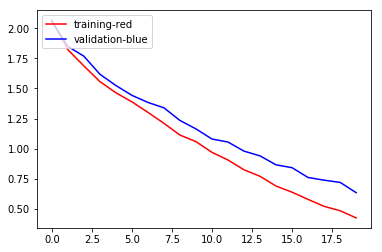

In [6]:
cnn = BasicCNN(10) 
#cnn.load_state_dict(torch.load('cnn.pt')['state_dict'])

optimizer = torch.optim.Adam(cnn.parameters(), weight_decay=0.0007)
trainCNN(cnn ,dataloaders,20,optimizer,3)

In [8]:
#Saving a checkpoint
torch.save(cnn.state_dict(), "cnn.pt")
#torch.save(checkpoint, 'cnn.pt')
#Loading a checkpoint
#checkpoint = torch.load( 'cnn.pt')

'''
checkpoint = {'model': BasicCNN(10),
          'state_dict': cnn_model.state_dict(),
          'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'cnn.pt')
'''


"\ncheckpoint = {'model': BasicCNN(10),\n          'state_dict': cnn_model.state_dict(),\n          'optimizer' : optimizer.state_dict()}\n\ntorch.save(checkpoint, 'cnn.pt')\n"

δ) Αρχικοποιήστε ένα μοντέλο με αυτά τα βάρη για το πρόβλημα του ερωτήματος 10 και εκπαιδεύστε το
για λίγες εποχές (fine tuning) στο multitask dataset. Για ευκολία μπορείτε να αναφέρετε τα
αποτελέσματα μόνο για έναν από τους 3 άξονες.

In [10]:
model = BasicCNN(10)
model.load_state_dict(torch.load("cnn.pt"))
model.parameters

<bound method Module.parameters of BasicCNN(
  (l1): Layers(
    (conv): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (tanh): Tanh()
  )
  (l2): Layers(
    (conv): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (tanh): Tanh()
  )
  (l3): Layers(
    (conv): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (tanh): Tanh()
  )
  (l4): Layers(
    (conv): Conv2d(4, 2, kernel_size=(5, 5), stride=(1, 1), pad

Παρακάτω θα αλλάξουμε το τελευταίο layer από το να έχει 10 εξόδους , 1 ώστε να είναι regression πρόβλημα

In [11]:
model.fc1 = nn.Linear(8 * 80 * 2, 1)

In [12]:
model.parameters

<bound method Module.parameters of BasicCNN(
  (l1): Layers(
    (conv): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (tanh): Tanh()
  )
  (l2): Layers(
    (conv): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (tanh): Tanh()
  )
  (l3): Layers(
    (conv): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (tanh): Tanh()
  )
  (l4): Layers(
    (conv): Conv2d(4, 2, kernel_size=(5, 5), stride=(1, 1), pad

In [13]:
class MultiDatasetCnn(Dataset): ## expanding dimensions...
    def __init__(self, path, target ,train=True, max_length=-1, read_spec_fn=read_fused_spectrogram):
        label_dict = {'valence': 1, 'energy': 2, 'danceability': 3}
        self.label_idx = label_dict[target]
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index,self.label_idx)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
            
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype('float32')
        #print([f.shape for f in self.feats] )

    def get_files_labels(self, txt, label_idx ):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            l = l[0].split(',')
            _id = l[0]
            label = l[label_idx]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
        return files, labels
    
    

    def __getitem__(self, item):
        # TODO: Inspect output and comment on how the output is formatted
        l = min(self.lengths[item], self.max_length)
        return np.expand_dims(self.zero_pad_and_stack(self.feats[item]), 0), self.labels[item], l
        
    
    def __len__(self):
        return len(self.labels)

In [14]:
cnn_spec_valence = MultiDatasetCnn('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/','valence',train=True)
train_loader, val_loader = torch_train_val_split(cnn_spec_valence, 32 ,32, val_size=.2, shuffle=True)
dataloaders = {'train':train_loader,'val':val_loader}

Epoch: 1
[Epoch 1/20] [Batch 6/7] [Loss: 0.158733 (0.161031), Acc: 0.00% (0.00%)]Validation loss decreased (inf --> 0.161031).  Saving model ...
val Accuracy: 0.0
Epoch: 2
[Epoch 2/20] [Batch 6/7] [Loss: 0.068035 (0.088740), Acc: 0.00% (0.00%)]Validation loss decreased (0.161031 --> 0.088740).  Saving model ...
val Accuracy: 0.0
Epoch: 3
[Epoch 3/20] [Batch 6/7] [Loss: 0.121723 (0.062006), Acc: 0.00% (0.00%)]Validation loss decreased (0.088740 --> 0.062006).  Saving model ...
val Accuracy: 0.0
Epoch: 4
[Epoch 4/20] [Batch 6/7] [Loss: 0.093005 (0.065227), Acc: 0.00% (0.00%)]EarlyStopping counter: 1 out of 4
val Accuracy: 0.0
Epoch: 5
[Epoch 5/20] [Batch 6/7] [Loss: 0.090836 (0.054755), Acc: 0.00% (0.00%)]Validation loss decreased (0.062006 --> 0.054755).  Saving model ...
val Accuracy: 0.0
Epoch: 6
[Epoch 6/20] [Batch 6/7] [Loss: 0.079308 (0.046847), Acc: 0.00% (0.00%)]Validation loss decreased (0.054755 --> 0.046847).  Saving model ...
val Accuracy: 0.0
Epoch: 7
[Epoch 7/20] [Batch 6/7

ValueError: x and y must have same first dimension, but have shapes (20,) and (19,)

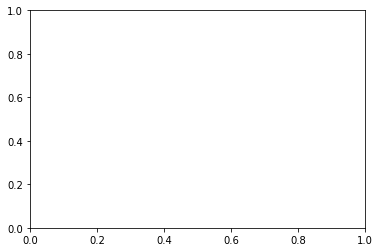

In [16]:
optimizerCNN = torch.optim.Adam(model.parameters(), weight_decay=0.001)
trainCNN(model ,dataloaders,20,optimizerCNN,4,True) # true for mseloss criterion

In [18]:
def CNN_REG(test_loader, model, criterion):
    predictions, y_test, test_loss = [], [], []
    model.eval()
    model.to(0)
    for i_batch, data_batched in enumerate(test_loader, 0):
        data_batched[0], data_batched[2] = data_batched[0].to(0), data_batched[2].to(0)
        y_pred = model(data_batched[0]).to(0)
        preds = y_pred.data.cpu().numpy()
        predictions += list(preds)
        # get sorted version of y_test
        data_batched[1] = data_batched[1].to(0)
        y_test += list(data_batched[1].data.cpu().numpy())
        loss = criterion(y_pred.squeeze(), data_batched[1]) 
        test_loss.append(loss.item()) 
    total_loss = np.mean(test_loss)
    print('Test loss: {}'.format(total_loss))
    return predictions, y_test

test_loader = DataLoader(cnn_spec_valence, batch_size=32)
criterion_regr = nn.MSELoss()
predictions_cnn, labels_cnn = CNN_REG(test_loader, model, criterion_regr)
spearmanr(labels_cnn, predictions_cnn) 

Test loss: 0.026717721613951854


SpearmanrResult(correlation=0.8186349088726046, pvalue=5.146567135881868e-272)

Παρατηρούμε πως σε σχέση με τα result του ερωτήματος 8 με το CNN πετυχαίνουμε καλύτερο loss αλλά πιο μικρό spearman correlation.

Παρακάτω είναι τα αποτελέσματα από το βήμα 8 για το valence με cnn.

test loss: 0.04630210085047616
SpearmanrResult(correlation=0.8333189995161571, pvalue=1.3358874111631322e-290)